In [1]:
from fastai.vision.all import *
from fastai.vision.data import *
from fastai.vision.core import *
from fastai2_extensions.interpret.all import *
# from fastai.imports import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
path = Path('../resources/feb2021_abclass')

In [4]:
vis_path = Path('visualizations_02-02-2021/round2')
os.path.exists(vis_path)

True

In [5]:
os.listdir(path)

['.DS_Store',
 'models',
 'val',
 'fastai_resnet50.pkl',
 '.ipynb_checkpoints',
 'train',
 'test']

In [6]:
import warnings

In [7]:
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [8]:
data = ImageDataLoaders.from_folder(path, train='train', valid='val', 
                                  batch_tfms=[*aug_transforms(flip_vert=False, max_lighting=0.1, max_zoom=1.0, max_warp=0, p_affine=0),Normalize.from_stats(*imagenet_stats)],
                                  bs=32, 
                                  resize_method=ResizeMethod.Squish,
                                  size=(512, 512), num_workers=16) 

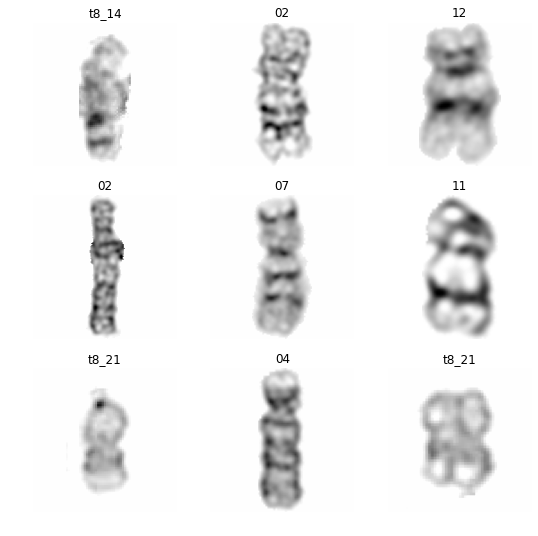

In [9]:
data.show_batch()

In [9]:
from fastai.metrics import error_rate, BalancedAccuracy, F1Score, RocAuc

In [10]:
f1_score = F1Score(average='weighted')
acc = BalancedAccuracy()

In [11]:
from fastai.imports import *
from fastai.torch_core import *
from fastai.learner import *
    
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

<h1><center style='background:orange'>ResNet50 Exp1</center></h1>

In [12]:
learn = cnn_learner(data, models.resnet50, metrics=[error_rate, acc, f1_score])

In [13]:
defaults.device = torch.device('cuda')

In [14]:
learn.recorder.summary()

Sequential (Input shape: 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 256 x 256 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     32 x 256 x 128 x 12 
Conv2d                                    16384      False     
BatchNorm2d                               512        True      
ReLU                                                           
__________________________________________

In [15]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [16]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,error_rate,balanced_accuracy_score,f1_score,time
0,2.188323,1.379542,0.416107,0.584330,0.557151,03:36
1,0.968101,0.807631,0.261745,0.700712,0.733179,03:33
2,0.525472,0.622584,0.191275,0.791453,0.805363,03:33


SuggestedLRs(lr_min=1.2022644114040304e-06, lr_steep=2.75422871709452e-06)

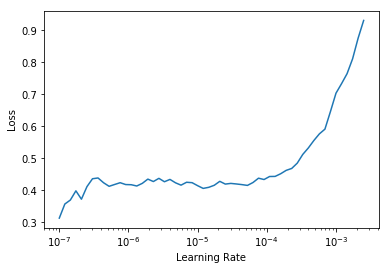

In [18]:
learn.unfreeze()
learn.lr_find()

In [19]:
learn.fit_one_cycle(5, slice(8e-5, 8e-4))

epoch,train_loss,valid_loss,error_rate,balanced_accuracy_score,f1_score,time
0,0.825078,1.288637,0.345638,0.624501,0.633523,04:29
1,0.504603,0.389207,0.117450,0.850427,0.880486,04:28
2,0.286315,0.242707,0.070470,0.918946,0.930047,04:28
3,0.115515,0.127752,0.033557,0.962536,0.966225,04:28
4,0.048067,0.109239,0.036913,0.956125,0.963362,04:28


In [20]:
learn.save('resnet50_exp1_shortcycle_bs32_is512.h5')

Path('feb2021_abclass/models/resnet50_exp1_shortcycle_bs32_is512.h5.pth')

<h1><center style='background:orange'>ResNet50 Exp2</center></h1>

In [11]:
learn = cnn_learner(data, models.resnet50, metrics=[error_rate, acc, f1_score])

In [12]:
defaults.device = torch.device('cuda')

In [13]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,error_rate,balanced_accuracy_score,f1_score,time
0,2.139931,1.473989,0.476510,0.524501,0.483552,03:37
1,1.030561,0.772899,0.228188,0.767094,0.768130,03:33
2,0.586878,0.635251,0.181208,0.807123,0.817174,03:33


SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=6.309573450380412e-07)

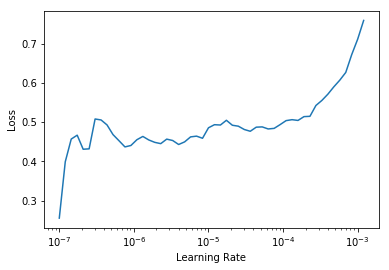

In [14]:
learn.unfreeze()
learn.lr_find()

In [16]:
learn.fit_one_cycle(5, slice(9e-5, 9e-4))

epoch,train_loss,valid_loss,error_rate,balanced_accuracy_score,f1_score,time
0,0.843156,2.111368,0.543624,0.414387,0.412858,04:28
1,0.544599,0.929422,0.234899,0.723504,0.769142,04:28
2,0.300547,0.493268,0.167785,0.799288,0.834719,04:28
3,0.108819,0.160982,0.040268,0.949715,0.959948,04:28
4,0.044387,0.123327,0.040268,0.957407,0.960011,04:28


In [17]:
learn.save('resnet50_exp2_shortcycle_bs32_is512.h5')

Path('feb2021_abclass/models/resnet50_exp2_shortcycle_bs32_is512.h5.pth')

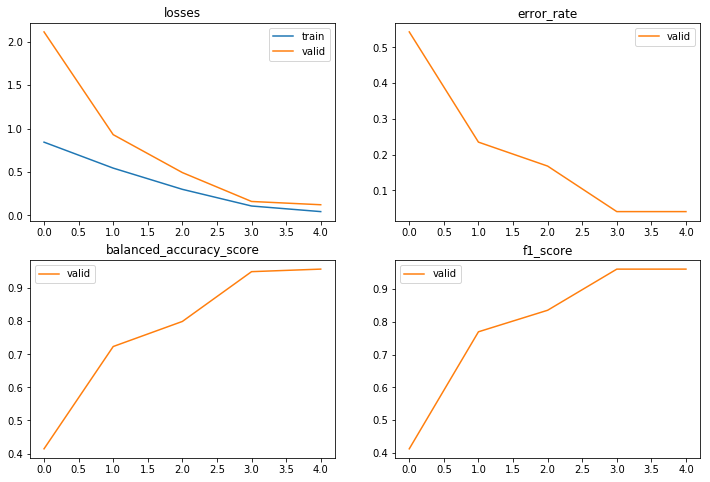

In [19]:
learn.recorder.plot_metrics()

<h1><center style='background:orange'>ResNet50 Exp3</center></h1>

In [11]:
learn = cnn_learner(data, models.resnet50, metrics=[error_rate, acc, f1_score])

In [12]:
defaults.device = torch.device('cuda')

In [14]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,error_rate,balanced_accuracy_score,f1_score,time
0,2.191448,1.614663,0.496644,0.502849,0.473497,03:41
1,1.045930,0.819158,0.265101,0.723789,0.727450,03:33
2,0.650772,0.698267,0.218121,0.759687,0.777618,03:33


SuggestedLRs(lr_min=1.58489319801447e-07, lr_steep=1.3182567499825382e-06)

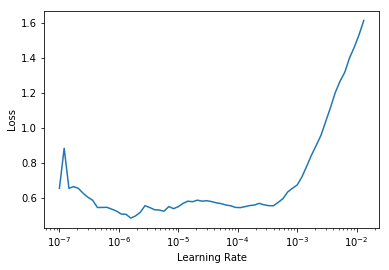

In [15]:
learn.unfreeze()
learn.lr_find()

In [16]:
learn.fit_one_cycle(5, slice(8e-5, 8e-4))

epoch,train_loss,valid_loss,error_rate,balanced_accuracy_score,f1_score,time
0,0.840406,0.901680,0.265101,0.717521,0.736632,04:28
1,0.512840,0.441150,0.140940,0.839601,0.852590,04:28
2,0.287361,0.285239,0.114094,0.873504,0.883042,04:28
3,0.113525,0.110431,0.026846,0.967949,0.972650,04:28
4,0.046900,0.081871,0.020134,0.976923,0.979619,04:27


In [18]:
learn.save('resnet50_exp3_shortcycle_bs32_is512.h5')

Path('feb2021_abclass/models/resnet50_exp3_shortcycle_bs32_is512.h5.pth')

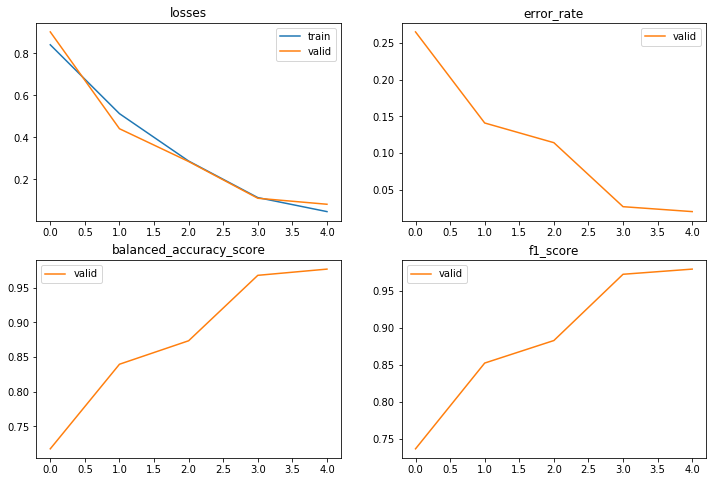

In [17]:
learn.recorder.plot_metrics()

In [40]:
import random 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
test_path = os.path.join(path,'test/')
test_imgs = []
for root, fir, fnames in os.walk(test_path):
    for fname in fnames: 
        if fname.endswith(('png', '.tif')): 
            test_imgs.append(os.path.join(root, fname))  
len(test_imgs)
test_imgs[:2]
img = random.choice(test_imgs)
img

337

['feb2021_abclass/test/03/50_chr3b.tif',
 'feb2021_abclass/test/03/33_chr3a.tif']

'feb2021_abclass/test/19/79_chr19b.tif'

In [53]:
img = test_imgs[298]
while 'inv16' not in img: 
    img = random.choice(test_imgs)
img

'feb2021_abclass/test/inv16/Screen Shot 2021-01-29 at 3.44.00 PM.png'

In [54]:
gcam = GradCam(learn, img, None)

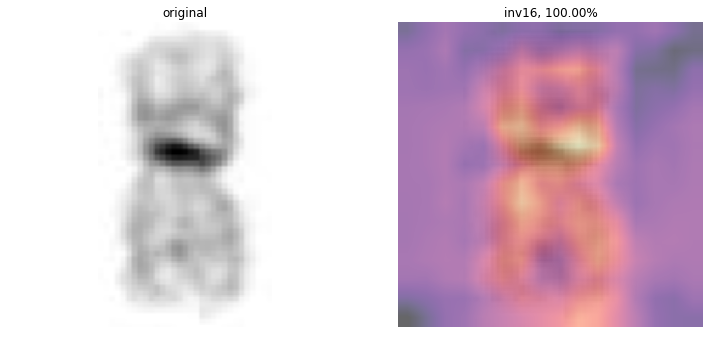

In [55]:
gcam.plot(full_size=True, plot_original=True, figsize=(12,6))

In [64]:
img = test_imgs[298]
while 'del5_22_35' not in img: 
    img = random.choice(test_imgs)
img

'feb2021_abclass/test/del5_22_35/Screen Shot 2021-01-13 at 10.54.17 AM.png'

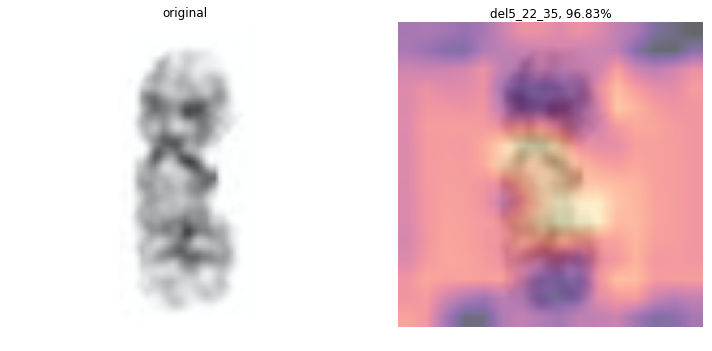

In [65]:
gcam = GradCam(learn, img, None)
gcam.plot(full_size=True, plot_original=True, figsize=(12,6))

In [66]:
img = test_imgs[298]
while 'del5_31_35' not in img: 
    img = random.choice(test_imgs)
img

'feb2021_abclass/test/del5_31_35/Screen Shot 2021-01-13 at 11.01.57 AM.png'

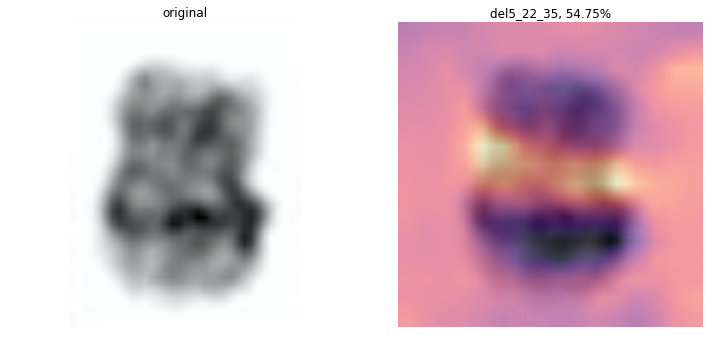

In [67]:
gcam = GradCam(learn, img, None)
gcam.plot(full_size=True, plot_original=True, figsize=(12,6))

In [68]:
img = test_imgs[298]
while '18' not in img: 
    img = random.choice(test_imgs)
img

'feb2021_abclass/test/18/67_chr18a.tif'

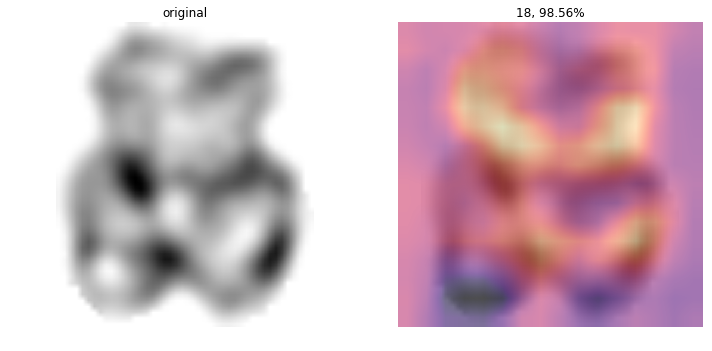

In [69]:
gcam = GradCam(learn, img, None)
gcam.plot(full_size=True, plot_original=True, figsize=(12,6))

In [16]:
interp = ClassificationInterpretation.from_learner(learn)

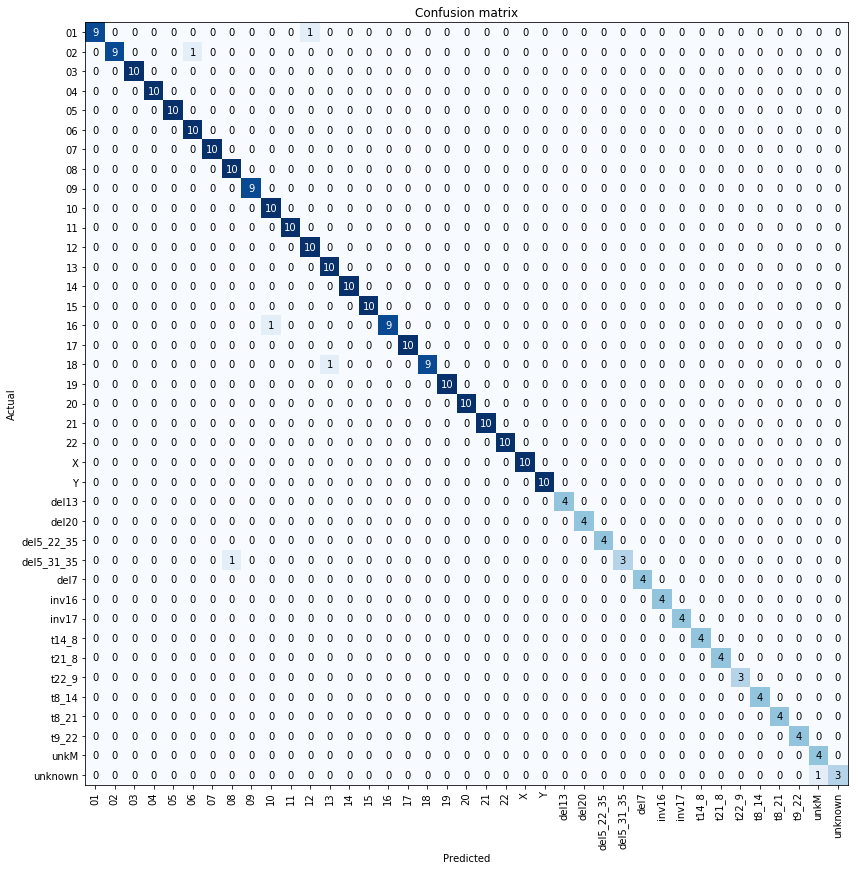

In [22]:
conf_mat = interp.plot_confusion_matrix(figsize=(12,12))

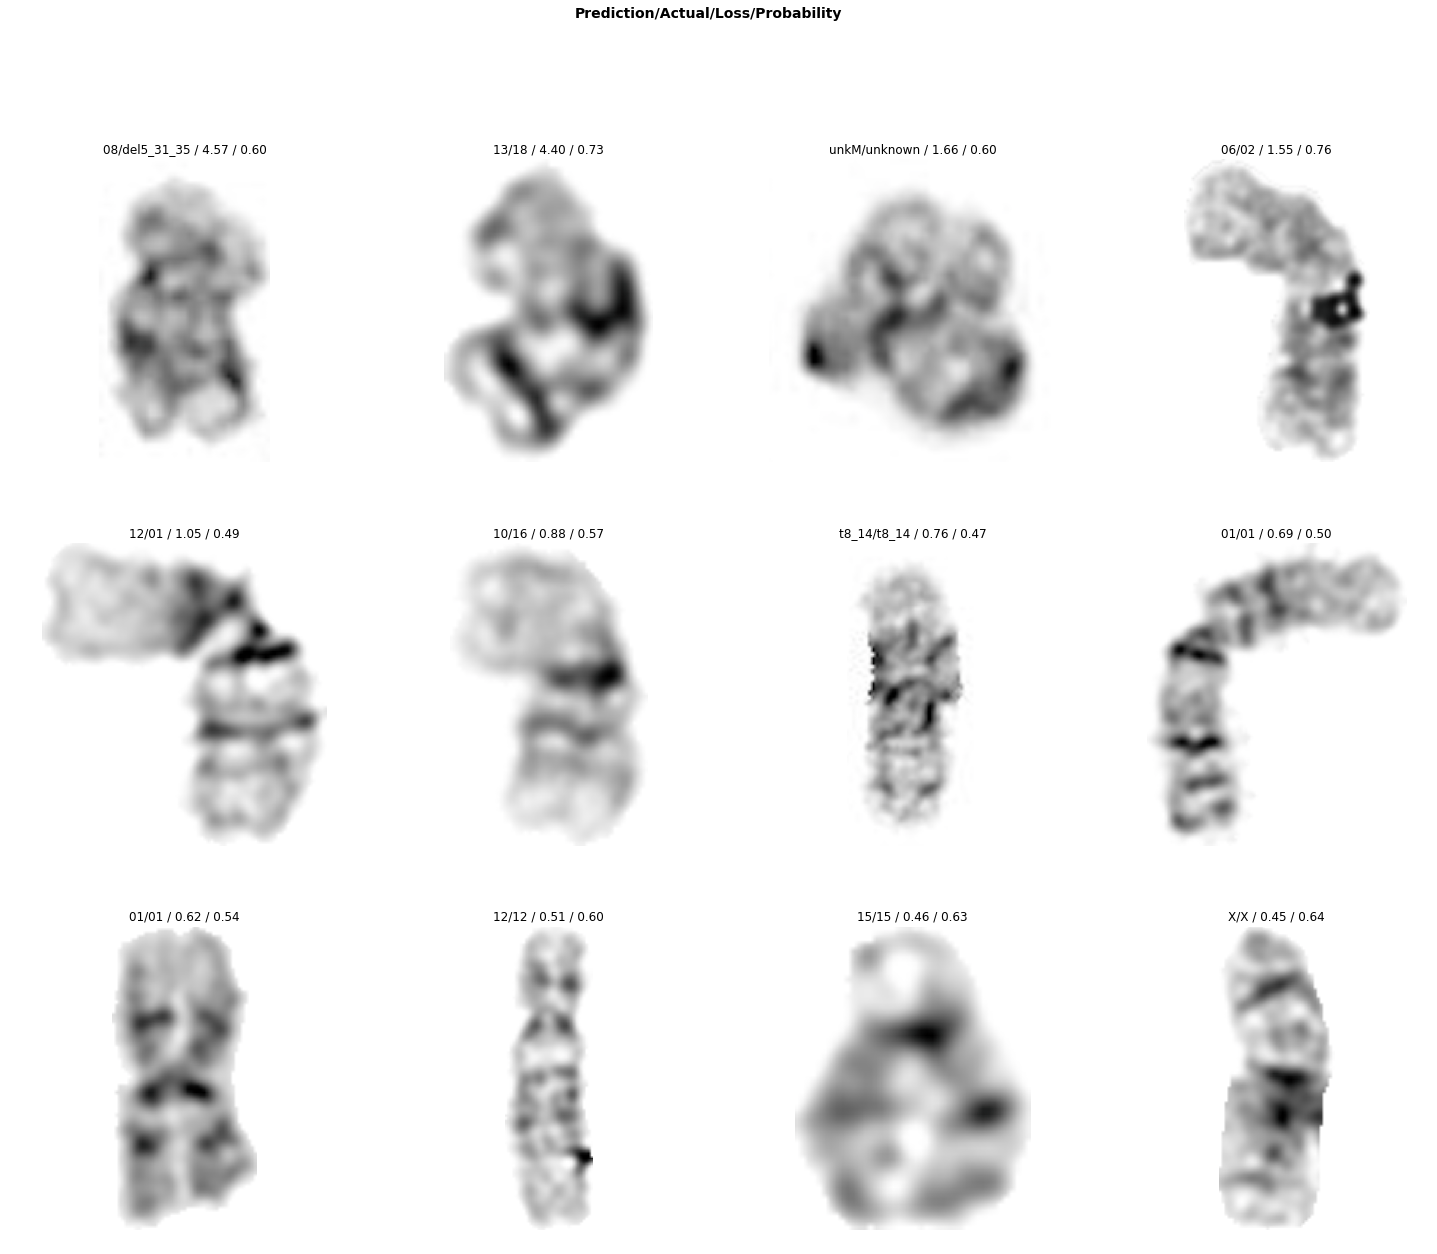

In [25]:
top_losses = interp.plot_top_losses(12, figsize=(25, 20))

In [17]:
interp.print_classification_report()

              precision    recall  f1-score   support

          01       1.00      0.90      0.95        10
          02       1.00      0.90      0.95        10
          03       1.00      1.00      1.00        10
          04       1.00      1.00      1.00        10
          05       1.00      1.00      1.00        10
          06       0.91      1.00      0.95        10
          07       1.00      1.00      1.00        10
          08       0.91      1.00      0.95        10
          09       1.00      1.00      1.00         9
          10       0.91      1.00      0.95        10
          11       1.00      1.00      1.00        10
          12       0.91      1.00      0.95        10
          13       0.91      1.00      0.95        10
          14       1.00      1.00      1.00        10
          15       1.00      1.00      1.00        10
          16       1.00      0.90      0.95        10
          17       1.00      1.00      1.00        10
          18       1.00    

# Exp3 on test data

In [8]:
data = ImageDataLoaders.from_folder(path, train='train', valid='test', 
                                  batch_tfms=[*aug_transforms(flip_vert=False, max_lighting=0.1, max_zoom=1.0, max_warp=0, p_affine=0),Normalize.from_stats(*imagenet_stats)],
                                  bs=32, 
                                  resize_method=ResizeMethod.Squish,
                                  size=(512, 512), num_workers=16) 

In [9]:
from fastai.metrics import error_rate, BalancedAccuracy, F1Score, RocAuc

In [10]:
f1_score = F1Score(average='weighted')
acc = BalancedAccuracy()

In [11]:
learn = cnn_learner(data, models.resnet50, metrics=[error_rate, acc, f1_score])

In [12]:
learn.load('resnet50_exp3_shortcycle_bs32_is512.h5')

In [13]:
interp = ClassificationInterpretation.from_learner(learn)

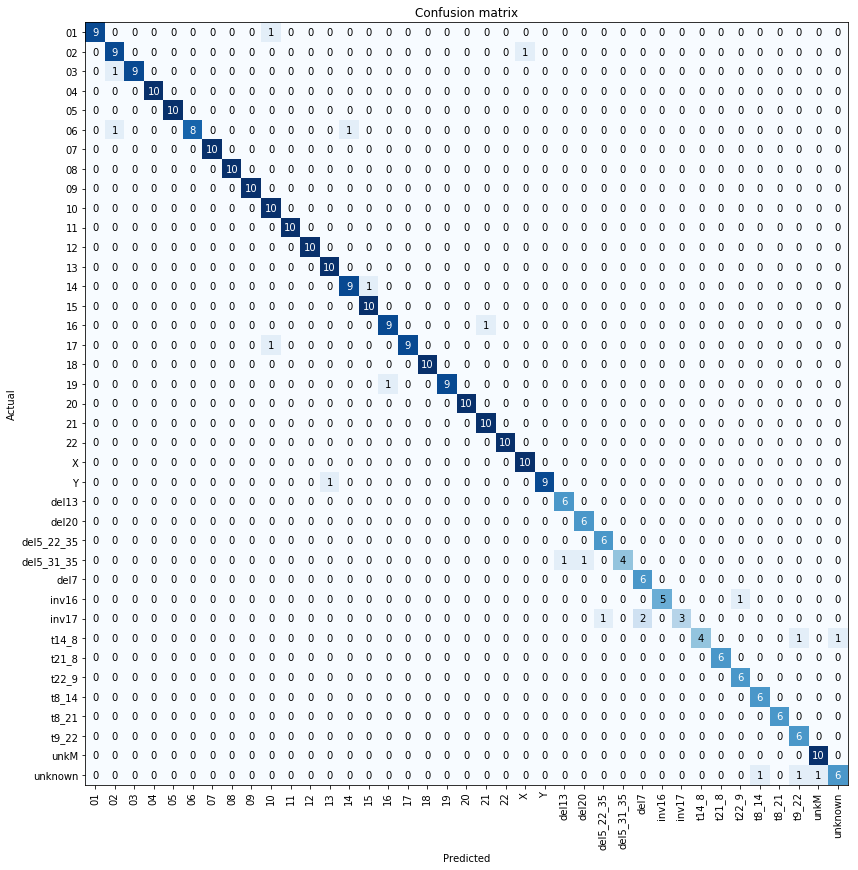

In [14]:
conf_mat = interp.plot_confusion_matrix(figsize=(12,12))

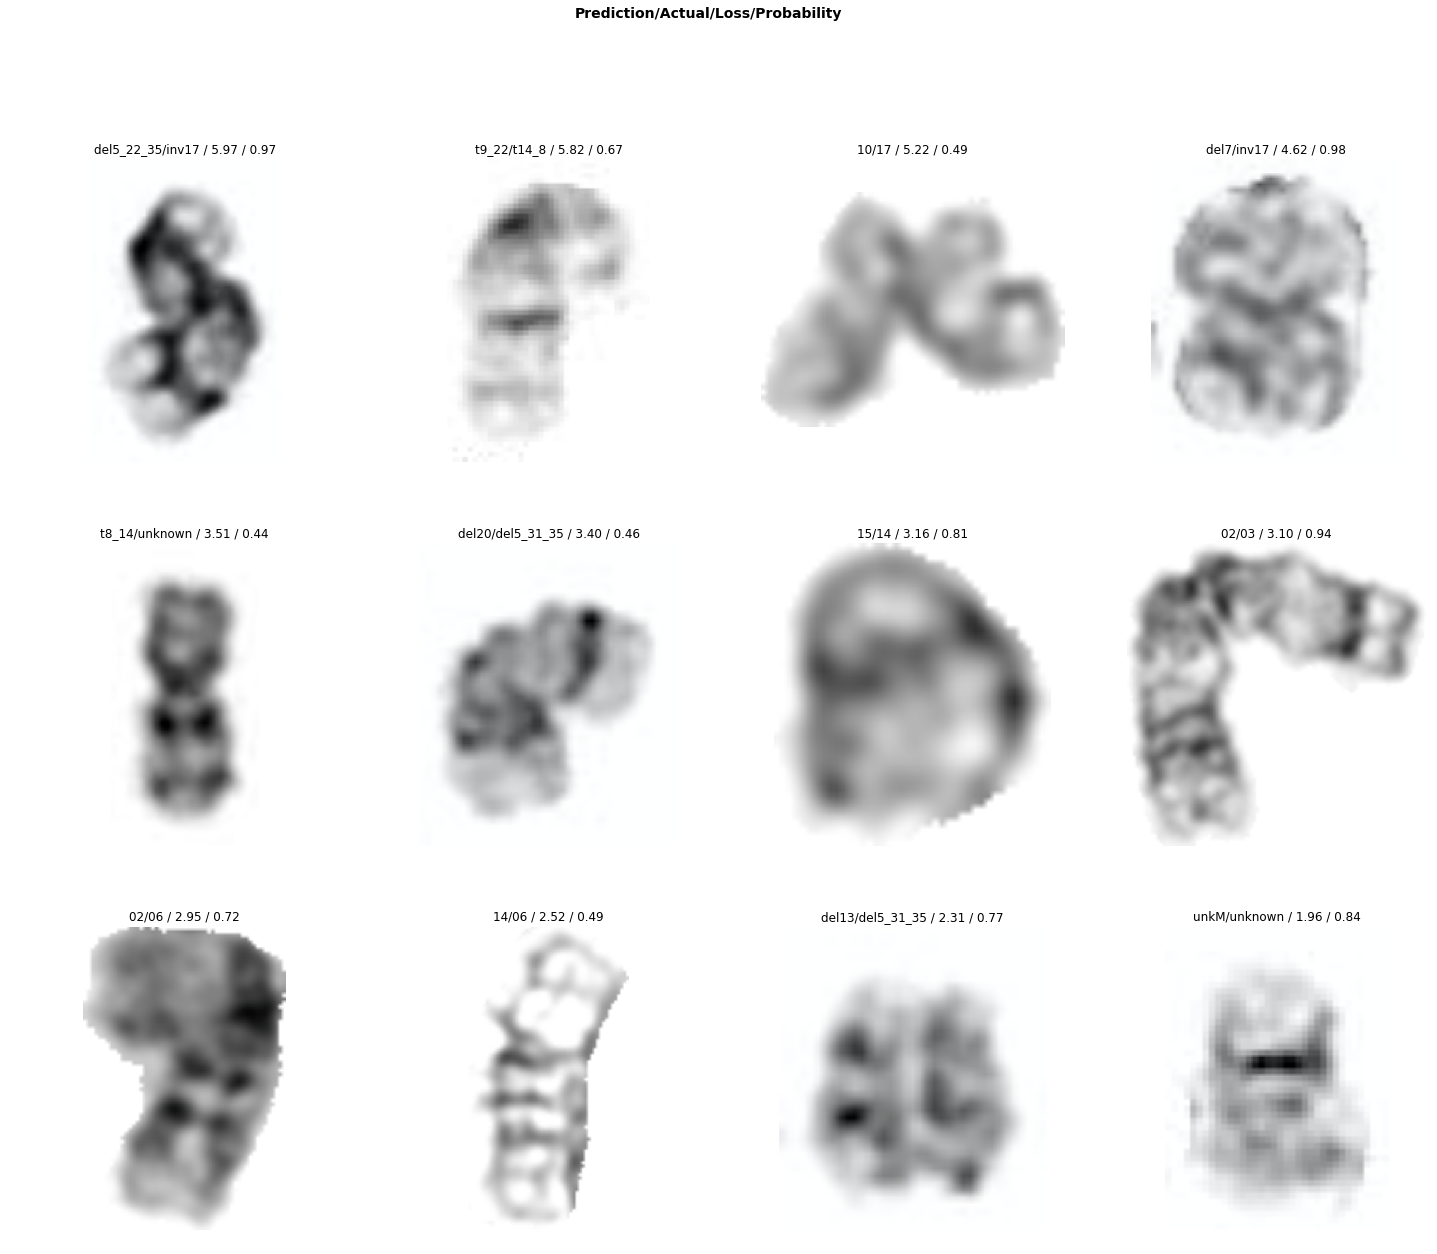

In [15]:
top_losses = interp.plot_top_losses(12, figsize=(25, 20))

In [18]:
y = interp.targs
p = interp.decoded

In [19]:
from sklearn.metrics import f1_score

In [20]:
f1_score(y, p, average='weighted')

0.9356714025384962

In [21]:
f1_score(y, p, average='macro')

0.9284435237876532

In [22]:
f1_score(y, p, average='micro')

0.9376854599406528

In [23]:
from sklearn.metrics import balanced_accuracy_score

In [24]:
balanced_accuracy_score(y, p)

0.9316239316239315

In [25]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve

In [26]:
preds = interp.preds

In [27]:
roc_auc_score(y, preds, multi_class='ovo', average='weighted')

0.9994355944262239

In [28]:
interp.print_classification_report()

              precision    recall  f1-score   support

          01       1.00      0.90      0.95        10
          02       0.82      0.90      0.86        10
          03       1.00      0.90      0.95        10
          04       1.00      1.00      1.00        10
          05       1.00      1.00      1.00        10
          06       1.00      0.80      0.89        10
          07       1.00      1.00      1.00        10
          08       1.00      1.00      1.00        10
          09       1.00      1.00      1.00        10
          10       0.83      1.00      0.91        10
          11       1.00      1.00      1.00        10
          12       1.00      1.00      1.00        10
          13       0.91      1.00      0.95        10
          14       0.90      0.90      0.90        10
          15       0.91      1.00      0.95        10
          16       0.90      0.90      0.90        10
          17       1.00      0.90      0.95        10
          18       1.00    